# Predicting Health Insurance

---

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

---

## Loading Data

In [2]:
df = pd.read_csv('../HealthInsurancePredictor/data/customer.csv')

df.head()

,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
0,7,000006646_03,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,1047,210.0,3,F
1,8,000007827_01,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,1047,3.0,6,T
2,9,000008359_04,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,1047,40.0,3,F
3,10,000008529_01,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,1047,120.0,2,F
4,11,000008744_02,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,1047,3.0,2,F


---

## Data Exploration

In [3]:
# Display the shape of the DataFrame (number of rows and columns)
df.shape

(72458, 15)

In [4]:
# Display information about the DataFrame including data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72458 entries, 0 to 72457
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      72458 non-null  int64  
 1   custid          72458 non-null  object 
 2   sex             72458 non-null  object 
 3   is_employed     46943 non-null  object 
 4   income          72458 non-null  float64
 5   marital_status  72458 non-null  object 
 6   health_ins      72458 non-null  bool   
 7   housing_type    70772 non-null  object 
 8   num_vehicles    70772 non-null  float64
 9   age             72458 non-null  int64  
 10  state_of_res    72458 non-null  object 
 11  code_column     72458 non-null  int64  
 12  gas_usage       70772 non-null  float64
 13  rooms           72458 non-null  int64  
 14  recent_move_b   70771 non-null  object 
dtypes: bool(1), float64(3), int64(4), object(7)
memory usage: 7.8+ MB


In [5]:
# Display summary statistics of the DataFrame
df.describe()

,Unnamed: 0,income,num_vehicles,age,code_column,gas_usage,rooms
count,72458.000000,7.245800e+04,70772.000000,72458.000000,72458.000000,70772.000000,72458.000000
mean,49910.637556,4.188143e+04,2.066820,49.208893,3285.523572,41.230501,3.494549
std,28772.082702,5.827460e+04,1.170076,18.090035,2661.775225,63.149323,1.706537
min,7.000000,-6.900000e+03,0.000000,0.000000,131.000000,1.000000,1.000000
25%,24911.250000,1.070000e+04,1.000000,34.000000,1305.000000,3.000000,2.000000
50%,49838.000000,2.640000e+04,2.000000,48.000000,2269.000000,10.000000,3.000000
75%,74786.750000,5.200000e+04,3.000000,62.000000,4979.000000,60.000000,5.000000
max,100000.000000,1.257000e+06,6.000000,120.000000,8962.000000,570.000000,6.000000


In [6]:
# Print the number of null values for each column
print("\nNull values per column:")
print(df.isnull().sum())


Null values per column:
Unnamed: 0            0
custid                0
sex                   0
is_employed       25515
income                0
marital_status        0
health_ins            0
housing_type       1686
num_vehicles       1686
age                   0
state_of_res          0
code_column           0
gas_usage          1686
rooms                 0
recent_move_b      1687
dtype: int64


In [7]:
# Print the number of duplicate rows
print("\nDuplicate rows:")
print(df.duplicated().sum())


Duplicate rows:
0


In [8]:
# Print the number of unique values for each column
print("\nUnique values per column:")
print(df.nunique())


Unique values per column:
Unnamed: 0        72458
custid            72458
sex                   2
is_employed           2
income             4445
marital_status        4
health_ins            2
housing_type          4
num_vehicles          7
age                  81
state_of_res         51
code_column          49
gas_usage            57
rooms                 6
recent_move_b         2
dtype: int64


---

## Data Preprocessing

# breve anlálise às colunas

- Unnamed: 0 - Esta coluna é tipo um índice, então é irrelevante

- custid - o id de cada cliente também não interessa

- sex - o género talvez possa ter influência sobre a conseguir um de seguro de saúde (?), ou influencia sobre outras coisas

- is_employed - emprego é como o genero. Só que há valores nulos aqui que temos de tratar

- income - é importante, também vai tar relacionada com o pagar seguro.

- marital_status - também importante

- health_ins - variável principal!! vamos ter de dizer se o cliente tem ou não seguro de saúde

- housing_type - tipo de habitação pode-se relacionar com estabilidade financeira

- num_vehicles - como o tipo de habitação.

- age - quanto mais velho mais dificil ter seguro (?)

- state_of_res - segundo o chatgpt o estado de residência pode ser útil "especialmente nos EUA, onde o acesso a seguros de saúde varia".

- code_column - indiferente

- gas_usage - também situação económica (maior consumo de gás pode indicar uma casa maior), mas não é muito claro, portanto vamos manter apenas se houver relação significativa com a variável principal

- rooms - também como o gas_usage

- recent_move_b - se for uma mudança recente (recent_move) poderá estar associada a uma nova situação financeira ou mudança de emprego, logo pode afetar a posse de seguro, vamos manter se tiver relação também



### Drop unnecessary columns

In [9]:
# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'custid', 'code_column'], errors='ignore')

df.head()

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b
0,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,210.0,3,F
1,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,3.0,6,T
2,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,40.0,3,F
3,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,120.0,2,F
4,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,3.0,2,F


### Handling missing values

#### Handling missing values in is_employed column

Estes vão ser os NaN's mais difíceis de tratar.. são 25515...

- dentro destes NaN's pessoas que:
    - tenham menos de 16 anos vou considerar que não trabalham
    - pessoas que têm income de 0 vou considerar que não trabalham
    - pessoas que tenham income e forem maiores que 16 anos, vou considerar que trabalham

In [10]:
# Display the count of unique values for the 'is_employed' column, including NaN values
df['is_employed'].value_counts(dropna=False)

is_employed
True     44630
NaN      25515
False     2313
Name: count, dtype: int64

In [11]:
# Menores de 16 anos -> 'False'
df.loc[(df['is_employed'].isna()) & (df['age'] < 16), 'is_employed'] = False

# Income igual a 0 -> 'False'
df.loc[(df['is_employed'].isna()) & (df['income'] == 0), 'is_employed'] = False

# Income maior que 0 e idade maior ou igual a 16 anos -> 'True'
df.loc[(df['is_employed'].isna()) & (df['income'] > 0) & (df['age'] >= 16), 'is_employed'] = True

# Verificar se ainda restam NaNs
print("Valores nulos após tratamento em 'is_employed':")
print(df['is_employed'].isnull().sum())


Valores nulos após tratamento em 'is_employed':
17


In [12]:
# print de 3 das linhas com os nulos que sobram
print(df[df['is_employed'].isnull()].head(3))

          sex is_employed  income marital_status  health_ins  \
8275   Female         NaN -2800.0        Married        True   
10503  Female         NaN -5400.0        Married        True   
13956  Female         NaN -4200.0        Married        True   

                       housing_type  num_vehicles  age state_of_res  \
8275   Homeowner with mortgage/loan           4.0   47   California   
10503  Homeowner with mortgage/loan           4.0   58   California   
13956  Homeowner with mortgage/loan           3.0   62  Connecticut   

       gas_usage  rooms recent_move_b  
8275       100.0      4             F  
10503       50.0      5             F  
13956       10.0      2             F  


**Os 17 valores nulos que sobram são com o income negativo. Portanto vamos eliminar essas linhas e conseguimos já acabar com esses NaN's e ainda tratar desses outliers do income**

In [13]:
df = df[~((df['is_employed'].isna()))]

print("Valores nulos em 'is_employed' após remoção:")
print(df['is_employed'].isnull().sum())

Valores nulos em 'is_employed' após remoção:
0


#### Handling missing values in the rest of the columns

In [14]:
# Check for missing rows in the four columns
missing_housing = df['housing_type'].isnull()
missing_vehicles = df['num_vehicles'].isnull()
missing_gas = df['gas_usage'].isnull()
missing_recent_move = df['recent_move_b'].isnull()

# Combine the masks using logical AND
combined_missing = missing_housing & missing_vehicles & missing_gas & missing_recent_move

# Verify if the counts match and print results
print("Total missing in housing_type:", missing_housing.sum())
print("Total missing in num_vehicles:", missing_vehicles.sum())
print("Total missing in gas_usage:", missing_gas.sum())
print("Total missing in recent_move_b:", missing_recent_move.sum())
print("Rows missing in all four columns:", combined_missing.sum())

# Check if the missing rows are identical
if combined_missing.sum() == missing_housing.sum() == missing_vehicles.sum() == missing_gas.sum() == missing_recent_move.sum():
    print("The missing rows are identical across all four columns.")
else:
    print("The missing rows are NOT identical across all four columns.")


Total missing in housing_type: 1686
Total missing in num_vehicles: 1686
Total missing in gas_usage: 1686
Total missing in recent_move_b: 1687
Rows missing in all four columns: 1686
The missing rows are NOT identical across all four columns.


We analyzed the missing values in the columns `housing_type`, `num_vehicles`, `gas_usage`, and `recent_move_b`:
- `housing_type`, `num_vehicles`, and `gas_usage` each have **1,686 missing values**, all overlapping.
- `recent_move_b` has **1,687 missing values**, with one additional row missing only in this column.
- A total of **1,686 rows** have missing values in all four columns.

Since these rows account for only **2.3% of the dataset**, we decided to drop them. This approach ensures data quality while retaining 97.7% of the data for analysis and modeling.

In [15]:
# Drop rows where all four columns are missing
rows_to_drop = df[(df['housing_type'].isnull()) &
                  (df['num_vehicles'].isnull()) &
                  (df['gas_usage'].isnull()) &
                  (df['recent_move_b'].isnull())].index
df = df.drop(rows_to_drop)

# Drop the additional row with only `recent_move_b` missing
df = df[df['recent_move_b'].notnull()]

# Check the number of missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
sex               0
is_employed       0
income            0
marital_status    0
health_ins        0
housing_type      0
num_vehicles      0
age               0
state_of_res      0
gas_usage         0
rooms             0
recent_move_b     0
dtype: int64


### Handling outliers

In [16]:
# Numerical features to evaluate for outliers
numerical_features = ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms']

#### Detecting outliers

##### Distribution plots 

This section visualizes the distribution of numerical features to observe their overall shape and detect potential skewness or outliers. Features with a strong skew might require transformations before modeling.

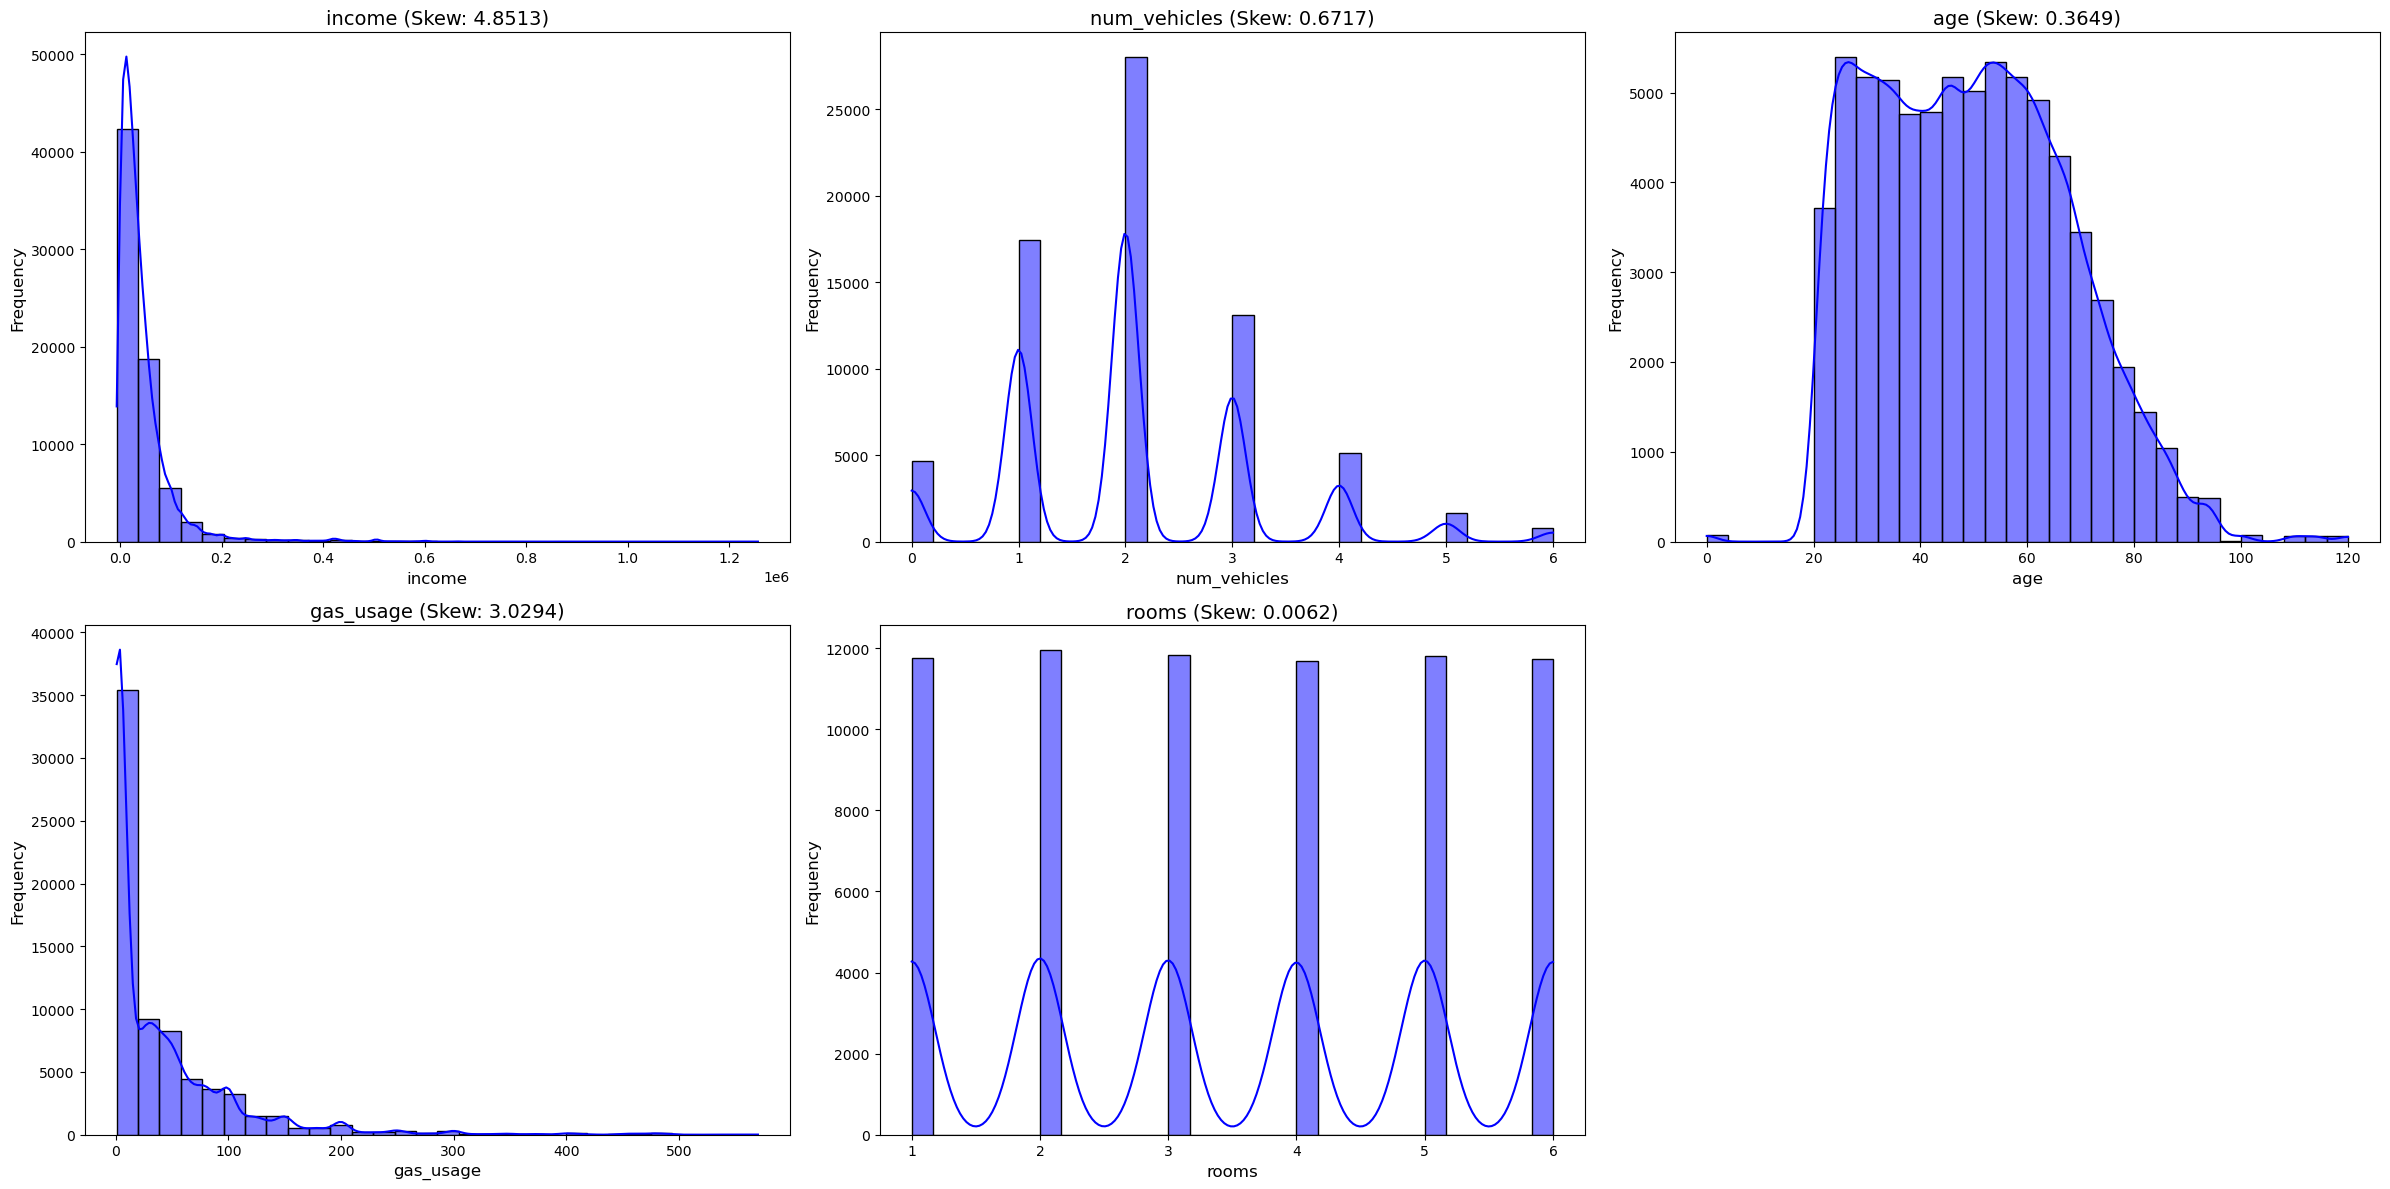

In [17]:
# Plot distribution of numerical features with skewness information
f, axes = plt.subplots(2, 3, figsize=(24, 12)) 
axes = axes.flatten()

# Loop through numerical features
for i, col in enumerate(df[numerical_features].columns):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color='blue', edgecolor='black')
    axes[i].set_title(f'{col} (Skew: {df[col].skew():.4f})', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# Hide any unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

##### Normal Probability Plots (Q-Q Plots)

These plots assess how well the data follows a normal distribution. Points deviating from the diagonal line indicate departures from normality, which may suggest outliers or the need for transformations.

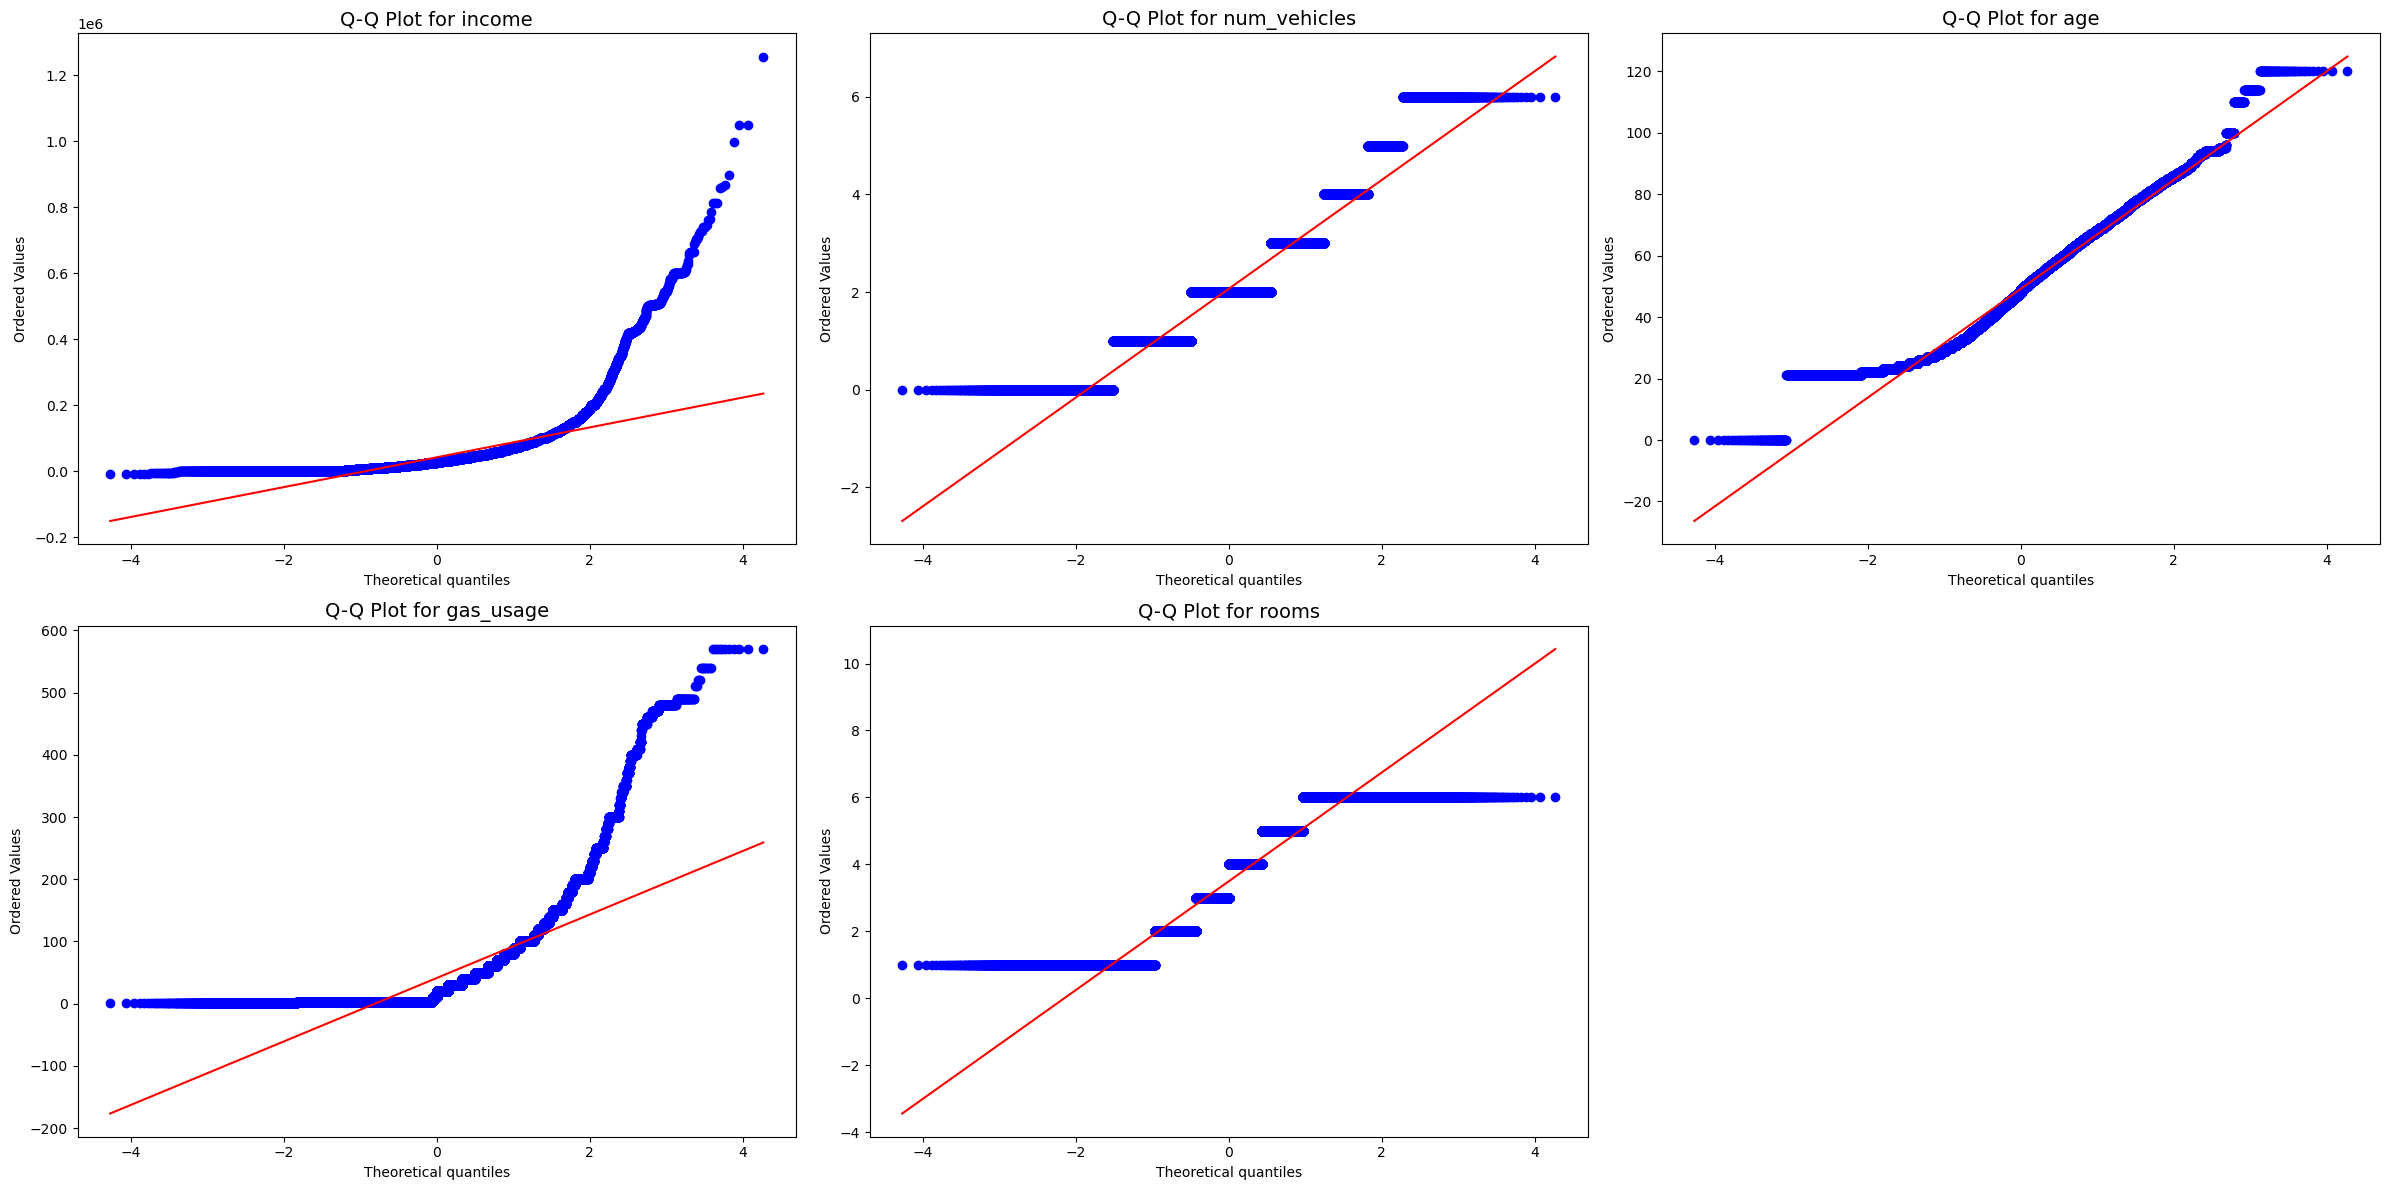

In [18]:
# Q-Q Plots for numerical features
f, axes = plt.subplots(2, 3, figsize=(24, 12)) 
axes = axes.flatten()

# Loop through numerical features
for i, col in enumerate(df[numerical_features].columns):
    stats.probplot(df[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {col}', fontsize=14)

# Hide any unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

##### Box Plots

Boxplots visually represent the spread of data and highlight potential outliers as points outside the whiskers.

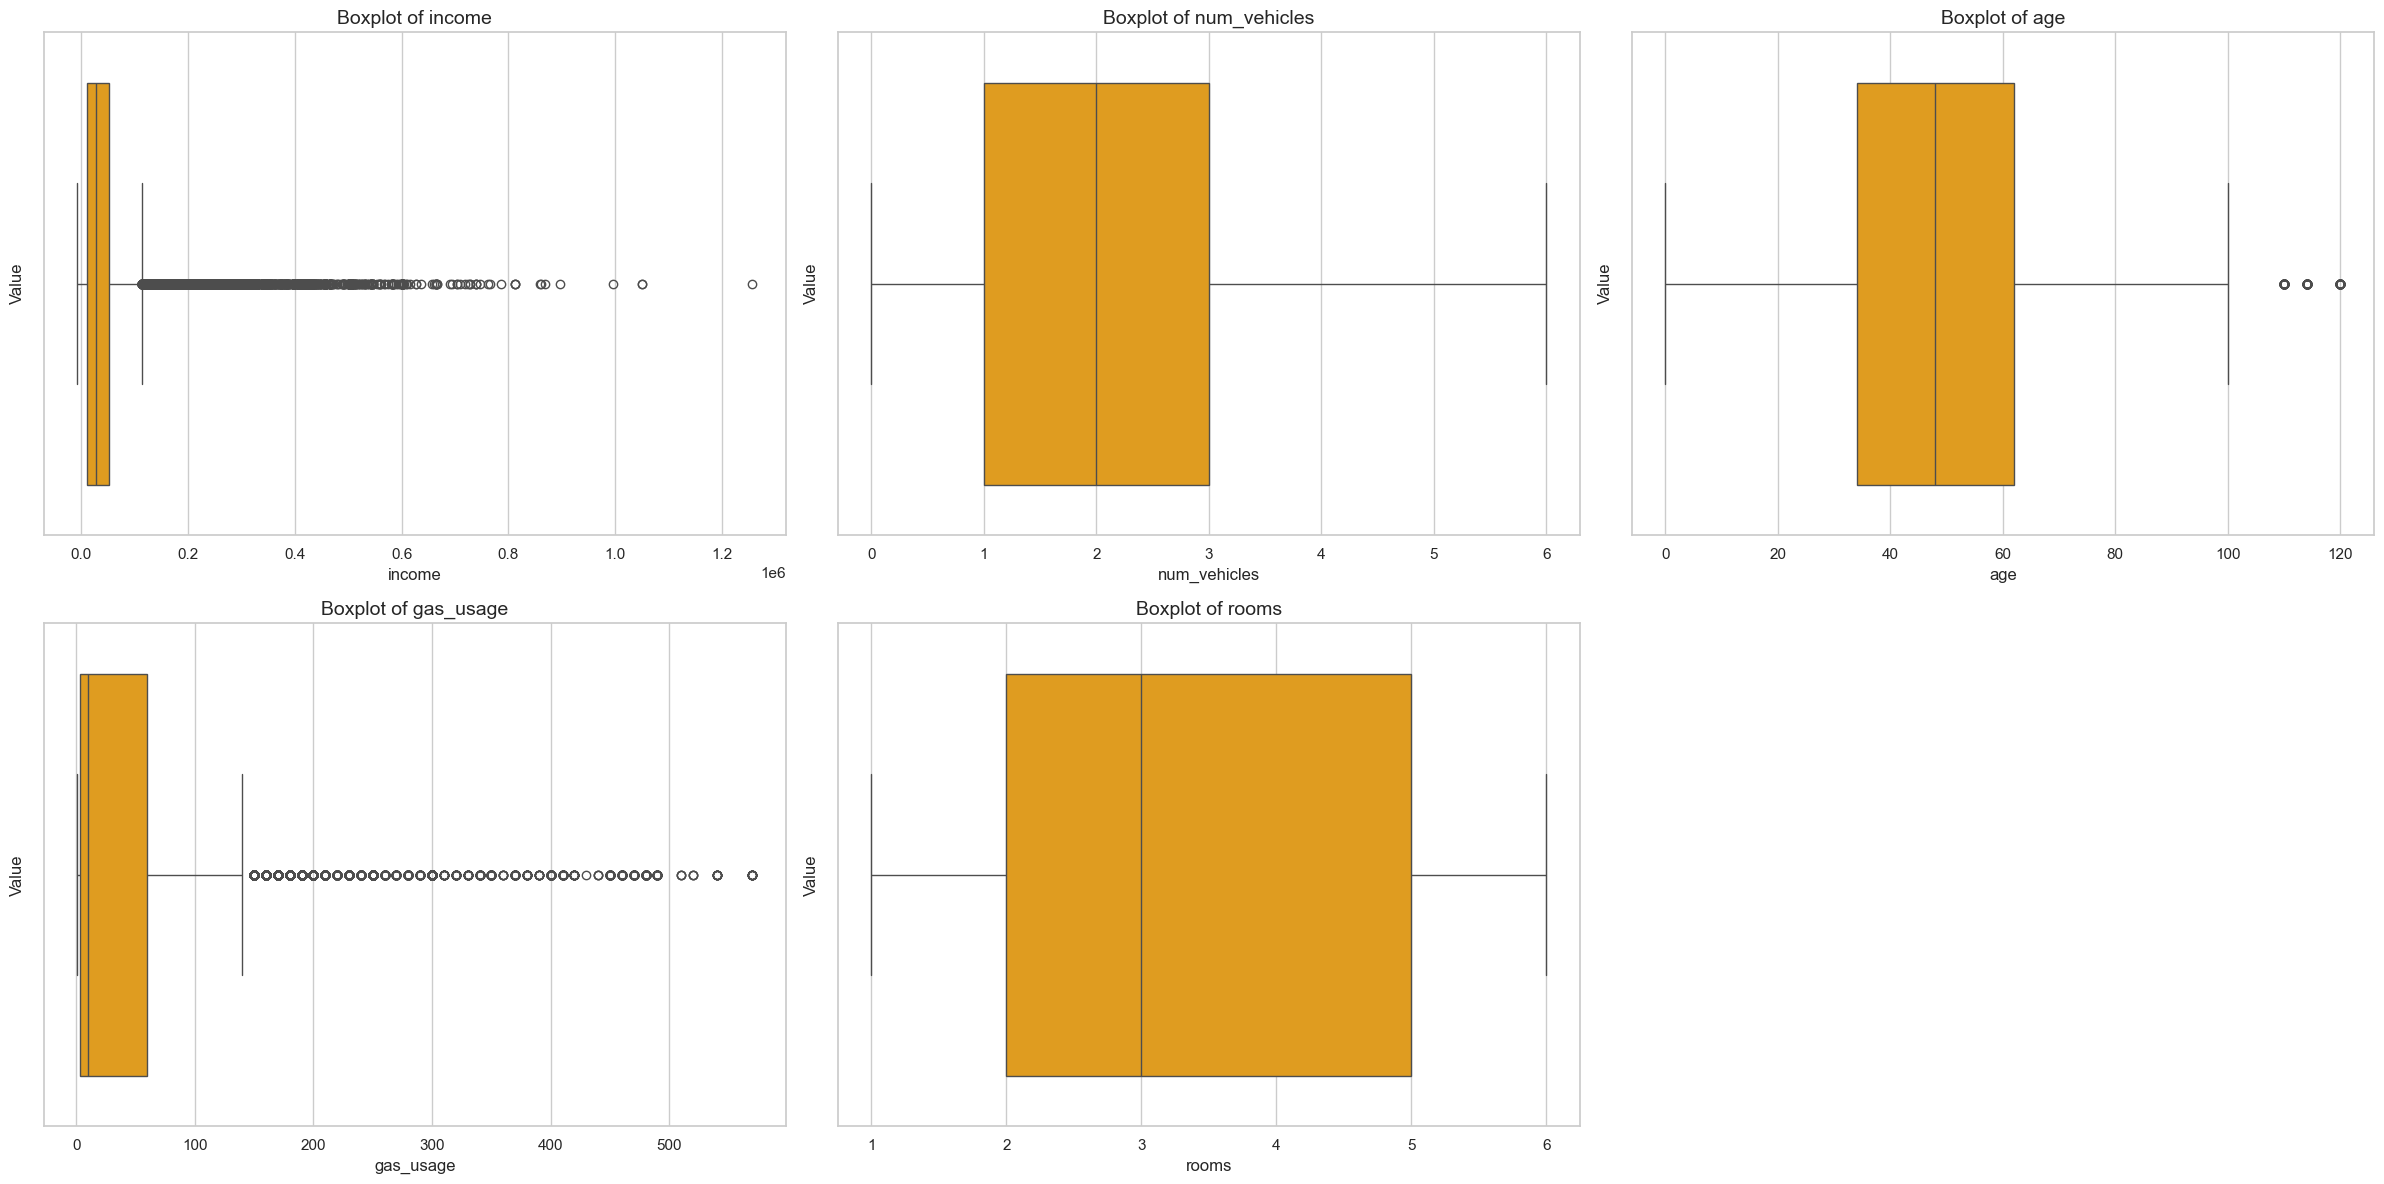

In [19]:
sns.set_theme(style="whitegrid", palette="pastel")

f, axes = plt.subplots(2, 3, figsize=(24, 12))  
axes = axes.flatten()

# Loop through numerical features and plot each
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], ax=axes[i], color='orange')
    axes[i].set_title(f'Boxplot of {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Value', fontsize=12)

# Hide unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


##### Scatter Plots

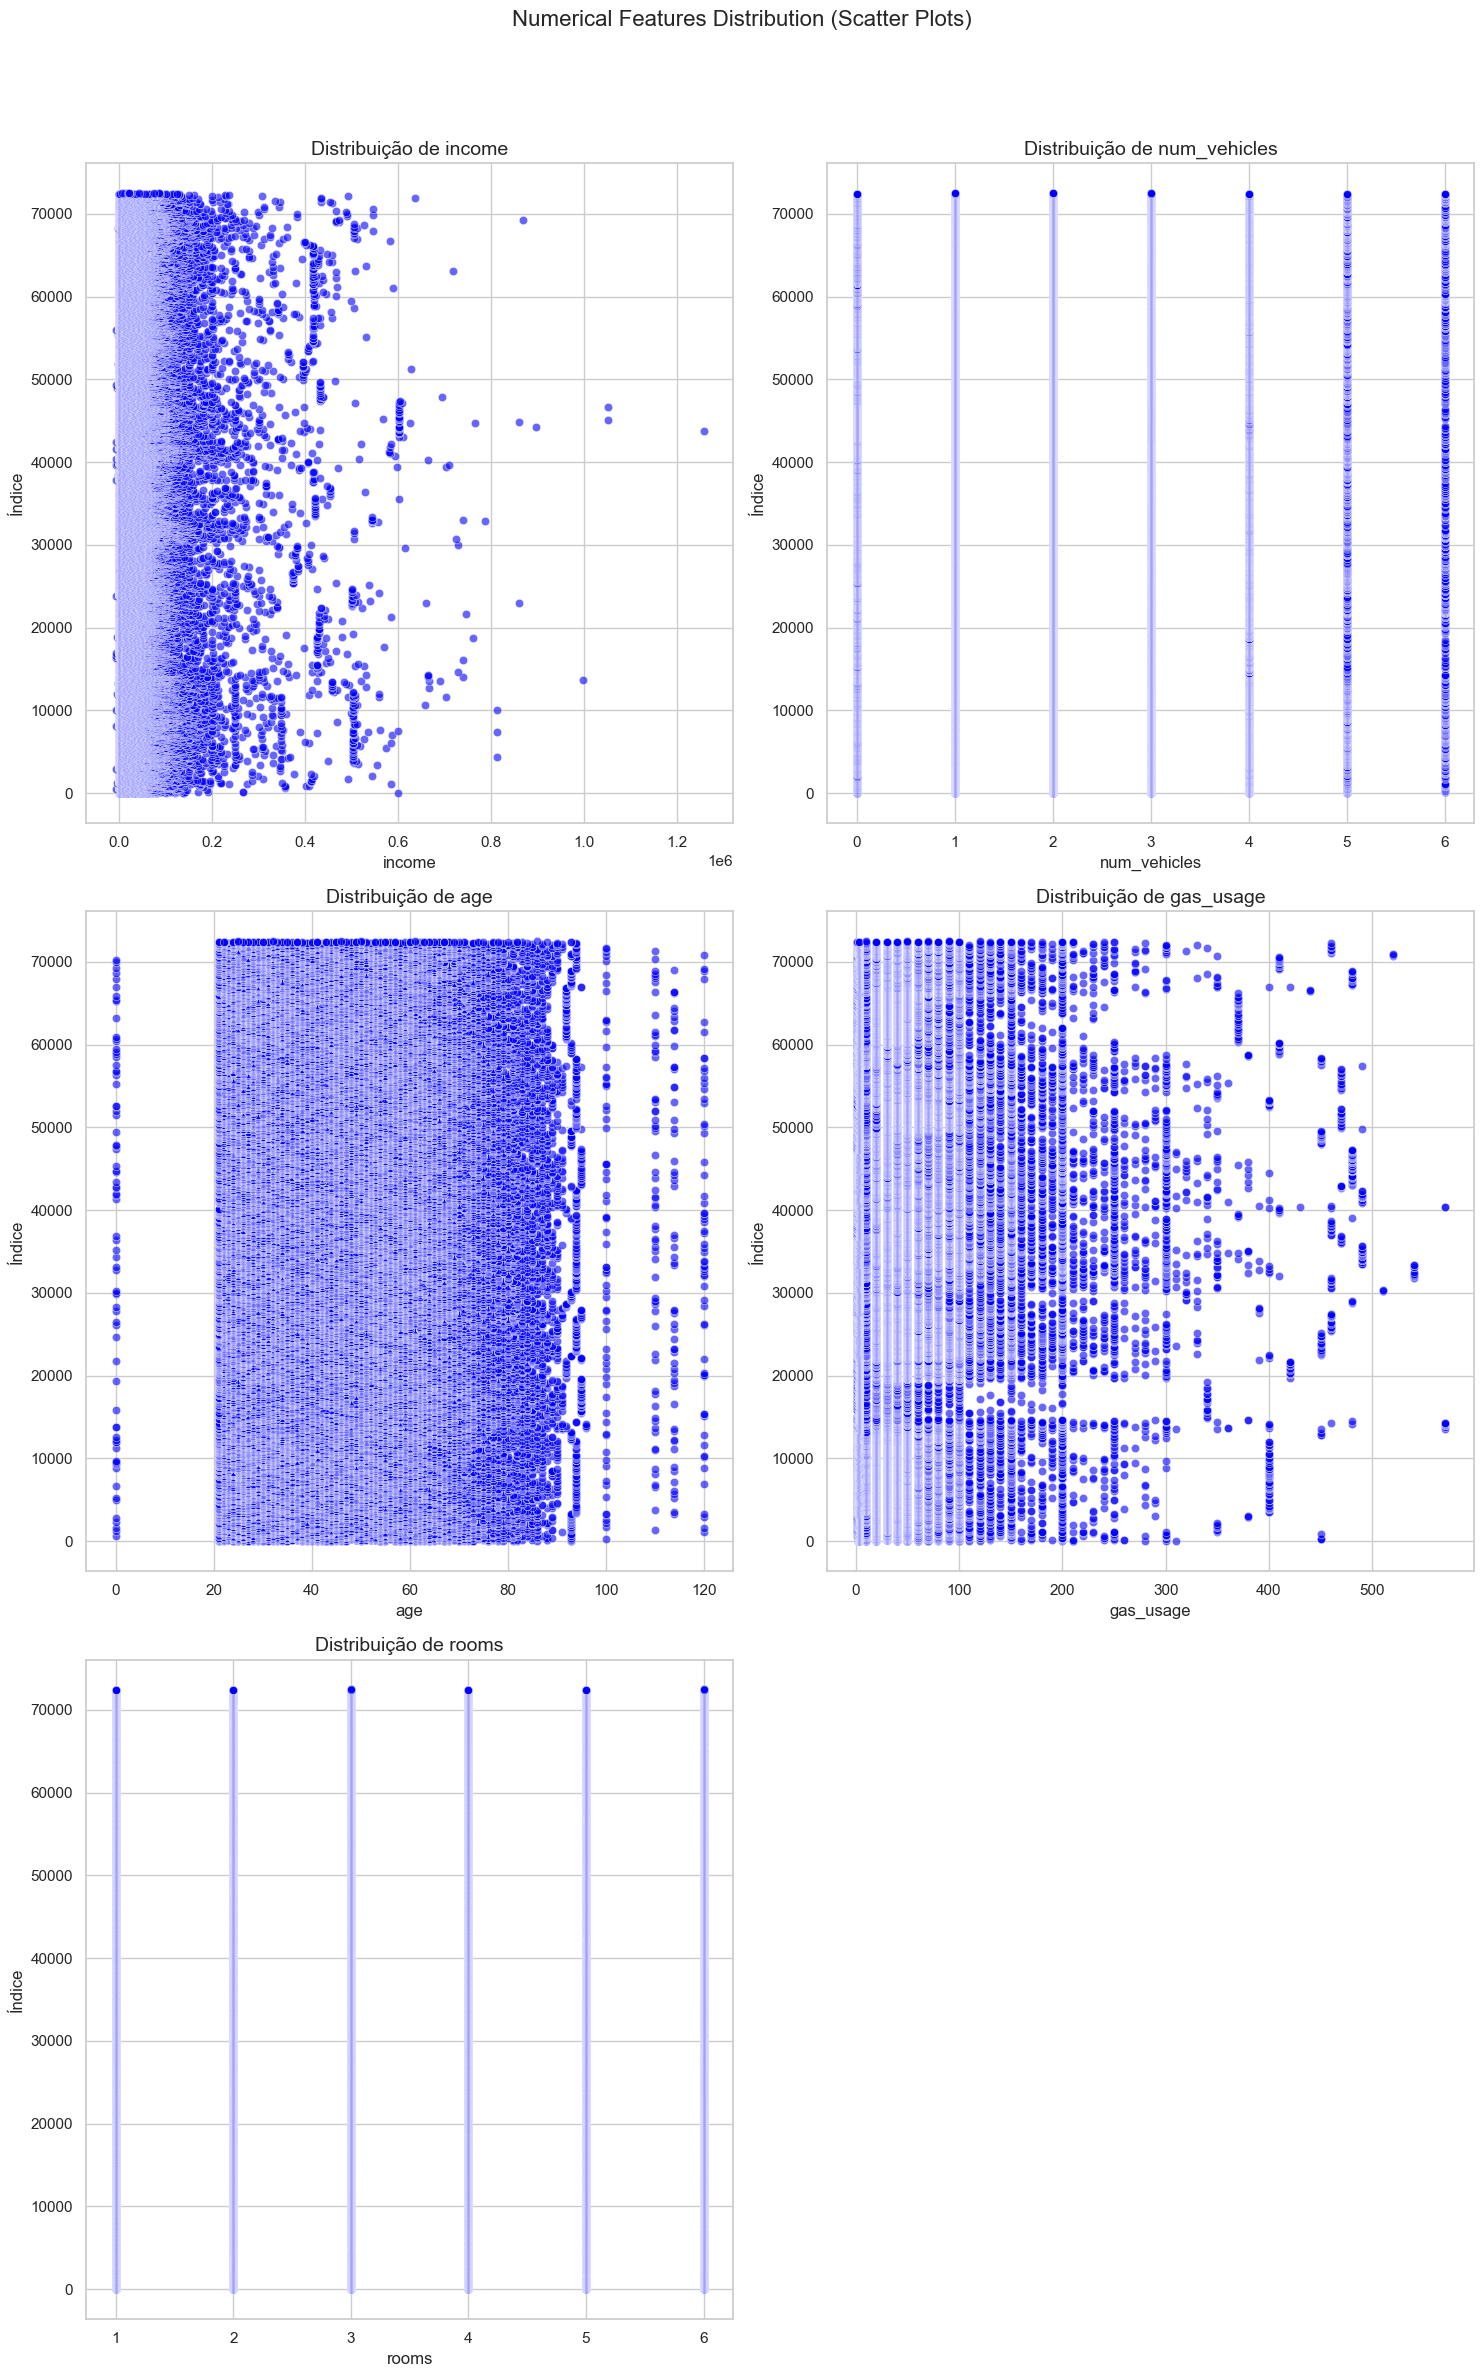

In [20]:
sns.set_theme(style="whitegrid", palette="pastel")

plt.figure(figsize=(15, 25))

# Create a scatter plot for each numerical feature
for i, feature in enumerate(numerical_features[:5], 1):
    plt.subplot(3, 2, i)  
    sns.scatterplot(data=df, x=feature, y=df.index, alpha=0.6, color='blue')  
    plt.title(f'Distribuição de {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Índice', fontsize=12)

plt.suptitle('Numerical Features Distribution (Scatter Plots)', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


#### Handling outliers in the income column

In [21]:
# Verify the presence of negative values in the 'income' column
negative_income = df['income'] < 0
print("Negative income values:", negative_income.sum())

Negative income values: 28


45 pois 17 já foram eliminados a cima ao tratar dos NaN's do is_employed

In [22]:
# Drop rows with negative income
df = df[df['income'] >= 0]

In [23]:
# Count the number of income values less than 10000
low_income = df['income'] < 15000
print("Income values less than 10000:", low_income.sum())

Income values less than 10000: 21968


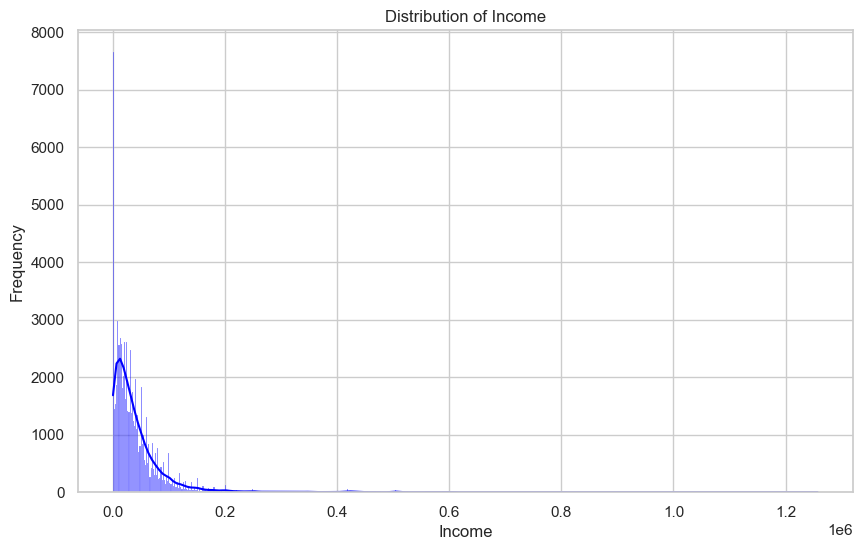

,income
count,7.072600e+04
mean,4.266208e+04
std,5.864869e+04
min,0.000000e+00
25%,1.130000e+04
50%,2.750000e+04
75%,5.210000e+04
max,1.257000e+06


In [24]:
# Check for the distribution of the income column to identify potential issues
plt.figure(figsize=(10, 6))
sns.histplot(df['income'], kde=True, color='blue')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

# Look at some of the extreme income values to spot any that appear to be monthly instead of annual
df[['income']].describe()

# outliers que temos de tratar

- no **income** os valores são `X * 10^6` , logo podem haver pessoas que tenham metido o income mensal (?) ou pessoas que tenham metido o income anual (?) -> convém definirmos um valor (tipo: salário minimo/médio dos EUA * 12, e se o income for menor que isso, então multiplicamos por 12, pois é sinal que essa pessoa meteu o mensal...podemos é dar uma margem para partimes ou assim...)
- na **idade** creio que há imensas pessoas perto de 120 anos, isso é normal (?) , e algumas com zero anos (?) -> e no gráfico mais a baixo vemos pessoas com zero anos a receberem income, como vamos tratar disso (?)
- **nr de veiculos** parece ok, vemos que as colunas 1,2,3 e 4 são bem marcadas, mas 5 e 6 já começam a ficar menos carregadas
- **uso do gas** parece que temos ali uns outliers à direita.. se calhar convém verificarmos se eles se relacionam com a casa ser grande / ter muitos quartos / têm muitaos carros... se isso se verificar é porque têm boa vida financeira, se não se verificar são outliers...
- o **nr de quartos** parece me tudo bem

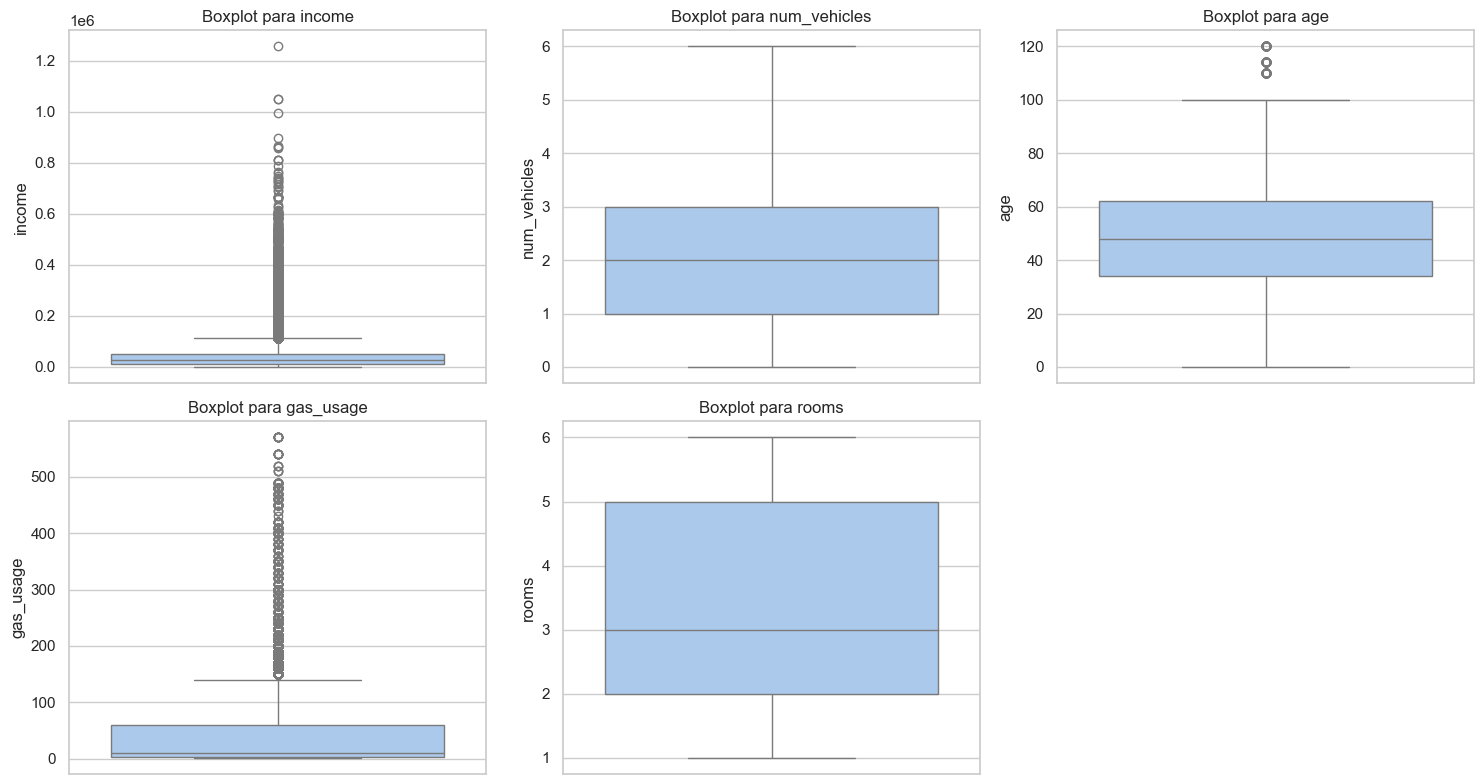

In [26]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot para {col}')
plt.tight_layout()
plt.show()

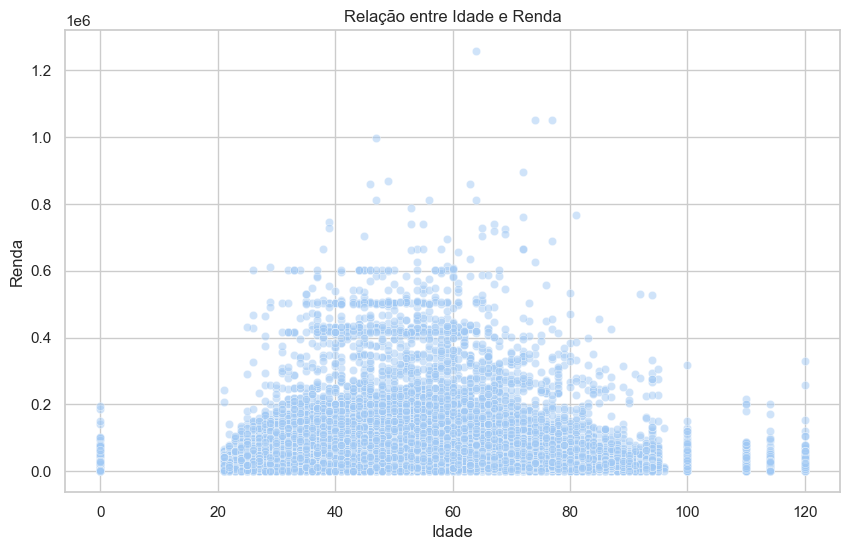

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='income', alpha=0.5)
plt.title('Relação entre Idade e Renda')
plt.xlabel('Idade')
plt.ylabel('Renda')
plt.show()

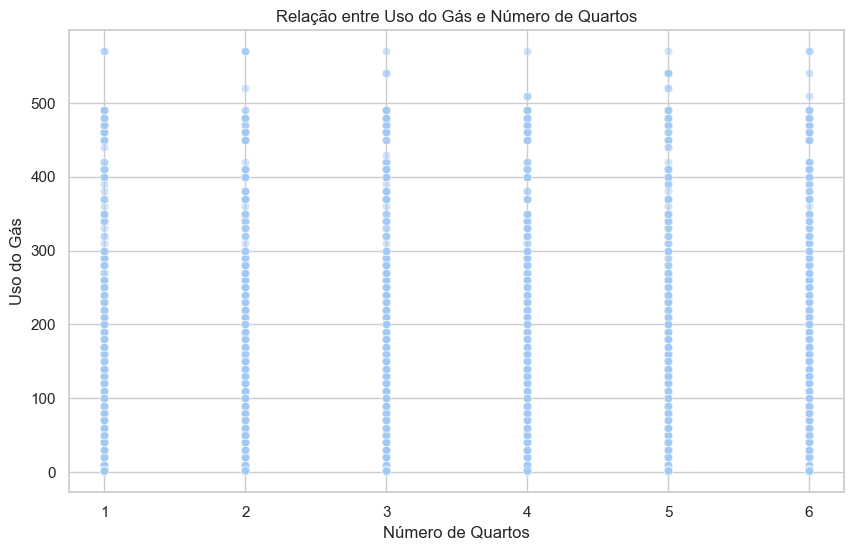

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='rooms', y='gas_usage', alpha=0.5)
plt.title('Relação entre Uso do Gás e Número de Quartos')
plt.xlabel('Número de Quartos')
plt.ylabel('Uso do Gás')
plt.show()

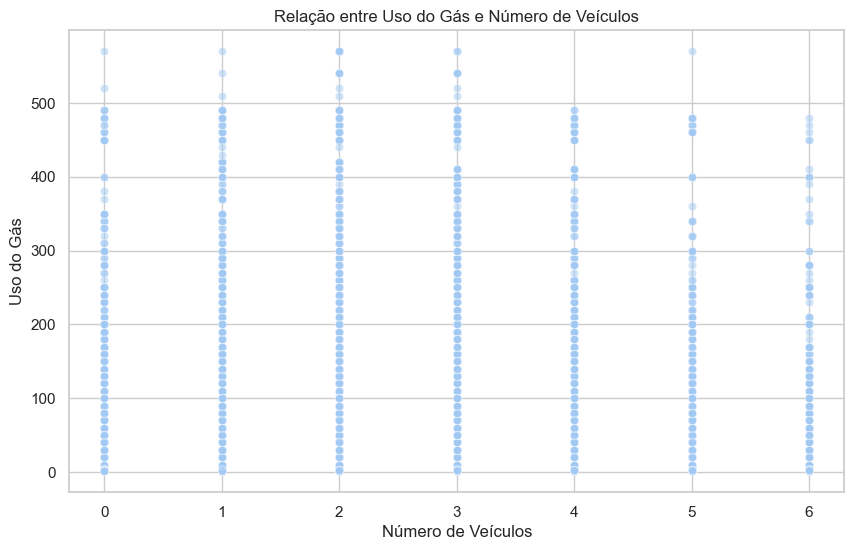

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='num_vehicles', y='gas_usage', alpha=0.5)
plt.title('Relação entre Uso do Gás e Número de Veículos')
plt.xlabel('Número de Veículos')
plt.ylabel('Uso do Gás')
plt.show()

# outliers do gas

Aqui parece que se confirmam que há outliers no uso do gas, se calhar é melhor lidarmos com eles

- pessoas que tenham :
    - 0 / 1 / 2 quartos && 0 / 1 carros -> não devem ter gás a cima de 450 (?)
    - 3 / 4 / 5 quartos && 0 / 1 / 2 / 3 carros -> não devem ter gás a cima de 500 (?)

# algo deste genero (?) -> se concordarem

In [30]:
condition1 = (df['rooms'].isin([0, 1, 2])) & (df['num_vehicles'].isin([0, 1])) & (df['gas_usage'] > 450)
df.loc[condition1, 'gas_usage'] = 450

condition2 = (df['rooms'].isin([3, 4, 5])) & (df['num_vehicles'].isin([0, 1, 2, 3])) & (df['gas_usage'] > 500)
df.loc[condition2, 'gas_usage'] = 500

print("Valores de gas_usage após tratamento:")
print(df['gas_usage'].describe())


Valores de gas_usage após tratamento:
count    70726.000000
mean        41.211521
std         63.012633
min          1.000000
25%          3.000000
50%         10.000000
75%         60.000000
max        570.000000
Name: gas_usage, dtype: float64


## ou
ou então podemos aplicar:
- uma transformação logaritmica 
- simplesmente remove-los

(oq eu fiz foi trocar pelo valor máximo)

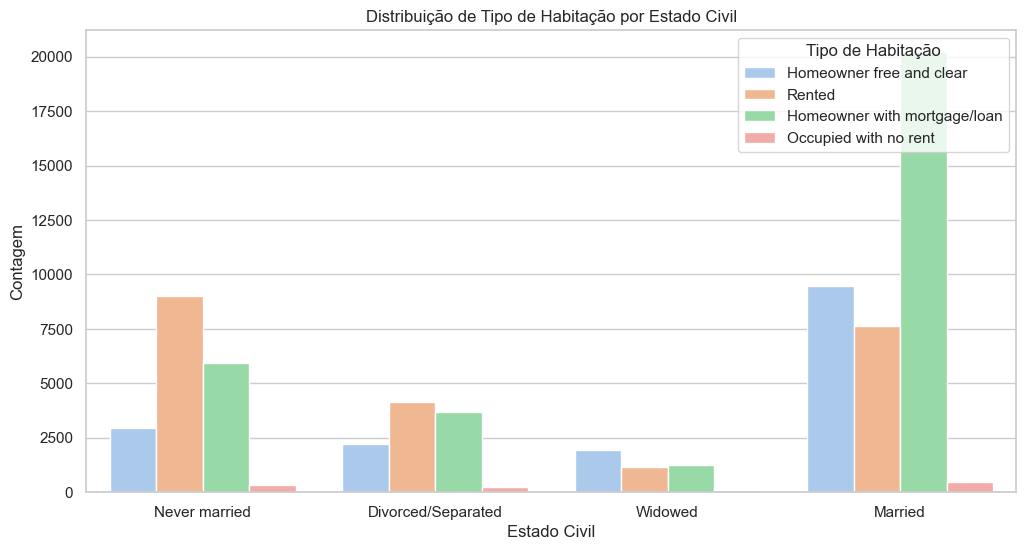

In [31]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='marital_status', hue='housing_type')
plt.title('Distribuição de Tipo de Habitação por Estado Civil')
plt.xlabel('Estado Civil')
plt.ylabel('Contagem')
plt.legend(title='Tipo de Habitação', loc='upper right')
plt.show()

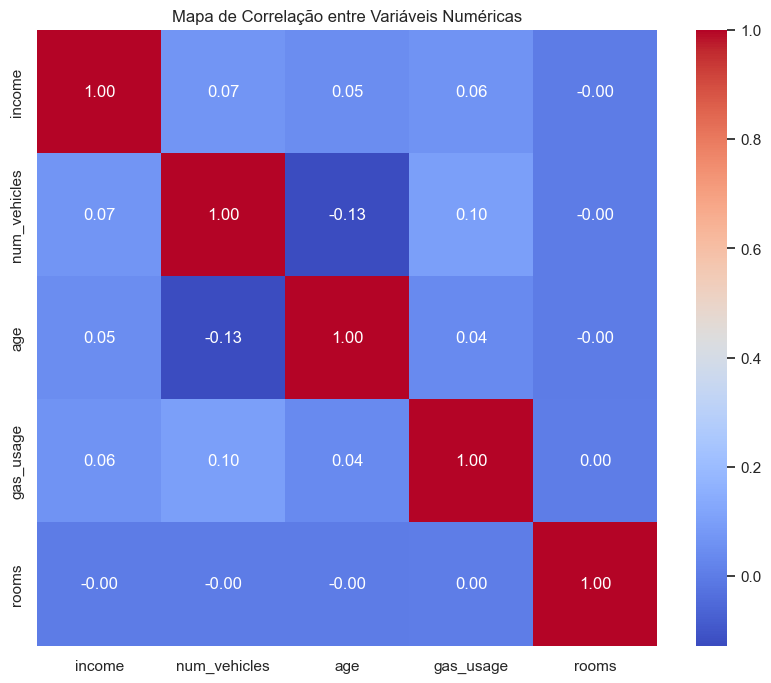

In [32]:
numeric_columns = df.select_dtypes(include=[np.number])
correlation = numeric_columns.corr()

# correlação entre variáveis numéricas
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlação entre Variáveis Numéricas')
plt.show()


/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_90014/2988973052.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='housing_type', y='income', ci=None)


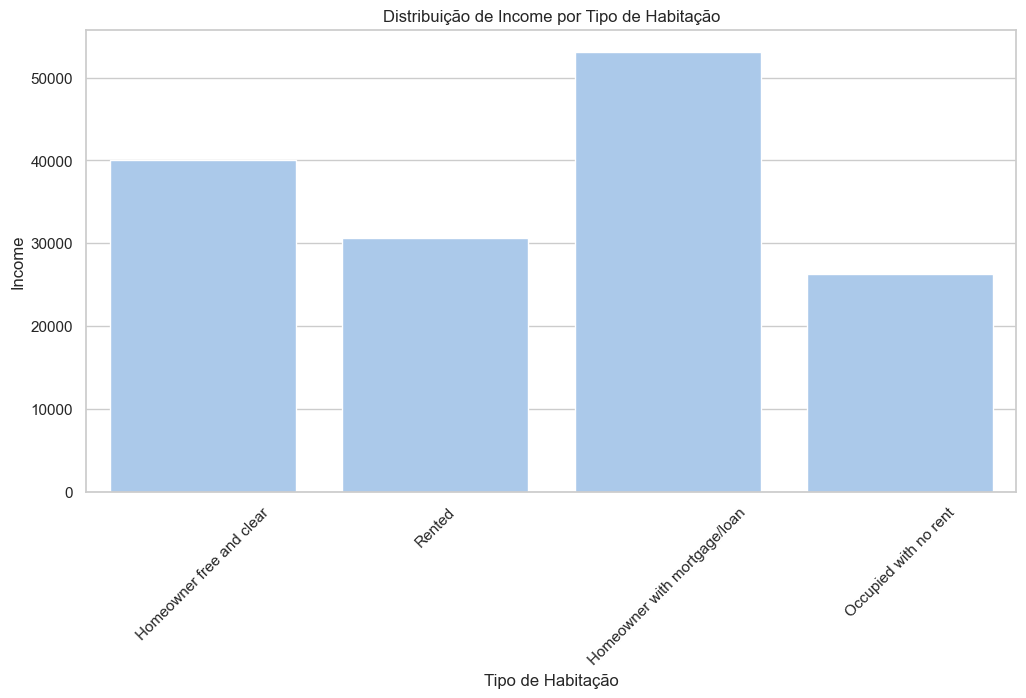

In [33]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='housing_type', y='income', ci=None)
plt.title('Distribuição de Income por Tipo de Habitação')
plt.xlabel('Tipo de Habitação')
plt.ylabel('Income')
plt.xticks(rotation=45)
plt.show()

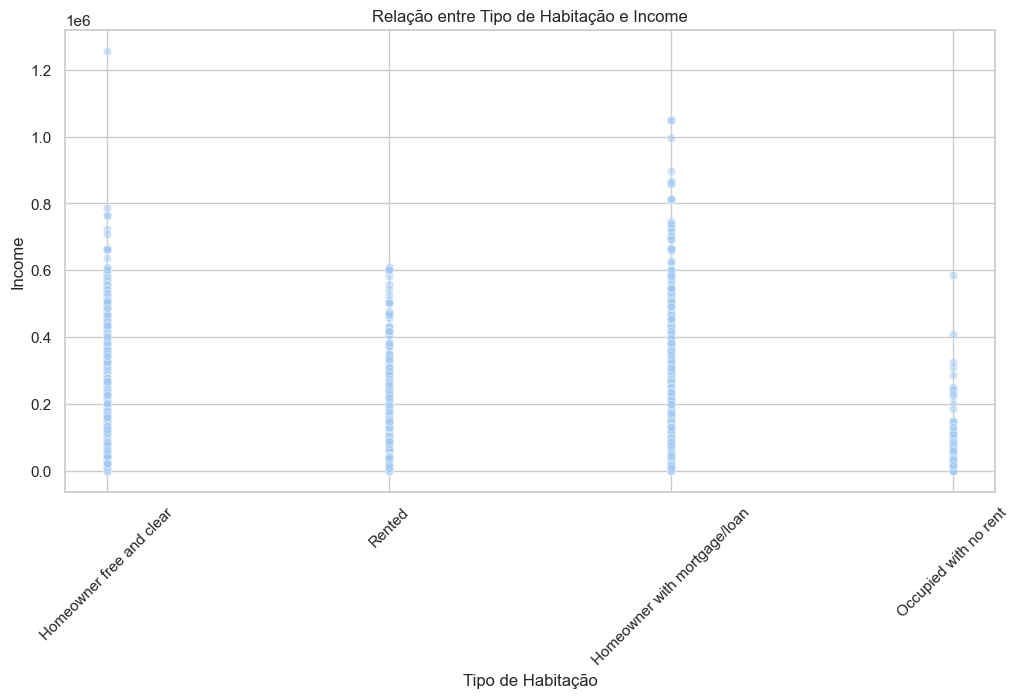

In [34]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='housing_type', y='income', alpha=0.5)
plt.title('Relação entre Tipo de Habitação e Income')
plt.xlabel('Tipo de Habitação')
plt.ylabel('Income')
plt.xticks(rotation=45)
plt.show()

# começar a preparar os modelos

#### começamos com um problema, que há uma grande disparidade entre o numero de true e o numero de falses

In [35]:
print(df['health_ins'].value_counts())

health_ins
True     64300
False     6426
Name: count, dtype: int64


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# passar colunas boolean para strings
for column in df.select_dtypes(include=['bool']).columns:
    df[column] = df[column].astype(str)

# verificar se ta tudo em strings
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str)

# encoding
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# separar as features e a variável alvo
X = df.drop(columns=['health_ins'])
y = df['health_ins']

# dividir os dados em treino e teste (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
print(f'K-Nearest Neighbors Accuracy: {accuracy_knn:.2f}')
print(f'K-Nearest Neighbors F1 Score: {f1_knn:.2f}')

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt:.2f}')
print(f'Decision Tree F1 Score: {f1_dt:.2f}')

svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc) 
print(f'Support Vector Machine Accuracy: {accuracy_svc:.2f}')
print(f'Support Vector Machine F1 Score: {f1_svc:.2f}')

K-Nearest Neighbors Accuracy: 0.90
K-Nearest Neighbors F1 Score: 0.95
Decision Tree Accuracy: 0.85
Decision Tree F1 Score: 0.92
Support Vector Machine Accuracy: 0.91
Support Vector Machine F1 Score: 0.95


# tentar corrigir a diferença entre true / falses 

### com smote

In [37]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# ver como ficaram as classes
print("Distribuição das classes após SMOTE:")
print(y_resampled.value_counts()) 


Distribuição das classes após SMOTE:
health_ins
1    51440
0    51440
Name: count, dtype: int64


# aplicar novamente os modelos

In [ ]:
knn.fit(X_resampled, y_resampled)
y_pred_knn_resampled = knn.predict(X_test)
accuracy_knn_resampled = accuracy_score(y_test, y_pred_knn_resampled)
f1_knn_resampled = f1_score(y_test, y_pred_knn_resampled)
print(f'K-Nearest Neighbors Accuracy (Resampled): {accuracy_knn_resampled:.2f}')
print(f'K-Nearest Neighbors F1 Score (Resampled): {f1_knn_resampled:.2f}')

dt.fit(X_resampled, y_resampled)
y_pred_dt_resampled = dt.predict(X_test)
accuracy_dt_resampled = accuracy_score(y_test, y_pred_dt_resampled)
f1_dt_resampled = f1_score(y_test, y_pred_dt_resampled)
print(f'Decision Tree Accuracy (Resampled): {accuracy_dt_resampled:.2f}')
print(f'Decision Tree F1 Score (Resampled): {f1_dt_resampled:.2f}')

svc.fit(X_resampled, y_resampled)
y_pred_svc_resampled = svc.predict(X_test)
accuracy_svc_resampled = accuracy_score(y_test, y_pred_svc_resampled)
f1_svc_resampled = f1_score(y_test, y_pred_svc_resampled)
print(f'Support Vector Machine Accuracy (Resampled): {accuracy_svc_resampled:.2f}')
print(f'Support Vector Machine F1 Score (Resampled): {f1_svc_resampled:.2f}')

K-Nearest Neighbors Accuracy (Resampled): 0.73
K-Nearest Neighbors F1 Score (Resampled): 0.83
Decision Tree Accuracy (Resampled): 0.83
Decision Tree F1 Score (Resampled): 0.90


### com undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("Distribuição após Under-sampling:")
print(y_resampled.value_counts())


In [ ]:
knn.fit(X_resampled, y_resampled)
y_pred_knn_resampled = knn.predict(X_test)
accuracy_knn_resampled = accuracy_score(y_test, y_pred_knn_resampled)
f1_knn_resampled = f1_score(y_test, y_pred_knn_resampled)
print(f'K-Nearest Neighbors Accuracy (Resampled): {accuracy_knn_resampled:.2f}')
print(f'K-Nearest Neighbors F1 Score (Resampled): {f1_knn_resampled:.2f}')

dt.fit(X_resampled, y_resampled)
y_pred_dt_resampled = dt.predict(X_test)
accuracy_dt_resampled = accuracy_score(y_test, y_pred_dt_resampled)
f1_dt_resampled = f1_score(y_test, y_pred_dt_resampled)
print(f'Decision Tree Accuracy (Resampled): {accuracy_dt_resampled:.2f}')
print(f'Decision Tree F1 Score (Resampled): {f1_dt_resampled:.2f}')

svc.fit(X_resampled, y_resampled)
y_pred_svc_resampled = svc.predict(X_test)
accuracy_svc_resampled = accuracy_score(y_test, y_pred_svc_resampled)
f1_svc_resampled = f1_score(y_test, y_pred_svc_resampled)
print(f'Support Vector Machine Accuracy (Resampled): {accuracy_svc_resampled:.2f}')
print(f'Support Vector Machine F1 Score (Resampled): {f1_svc_resampled:.2f}')

### com oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("Distribuição após Over-sampling:")
print(y_resampled.value_counts())


In [ ]:
knn.fit(X_resampled, y_resampled)
y_pred_knn_resampled = knn.predict(X_test)
accuracy_knn_resampled = accuracy_score(y_test, y_pred_knn_resampled)
f1_knn_resampled = f1_score(y_test, y_pred_knn_resampled)
print(f'K-Nearest Neighbors Accuracy (Resampled): {accuracy_knn_resampled:.2f}')
print(f'K-Nearest Neighbors F1 Score (Resampled): {f1_knn_resampled:.2f}')

dt.fit(X_resampled, y_resampled)
y_pred_dt_resampled = dt.predict(X_test)
accuracy_dt_resampled = accuracy_score(y_test, y_pred_dt_resampled)
f1_dt_resampled = f1_score(y_test, y_pred_dt_resampled)
print(f'Decision Tree Accuracy (Resampled): {accuracy_dt_resampled:.2f}')
print(f'Decision Tree F1 Score (Resampled): {f1_dt_resampled:.2f}')

svc.fit(X_resampled, y_resampled)
y_pred_svc_resampled = svc.predict(X_test)
accuracy_svc_resampled = accuracy_score(y_test, y_pred_svc_resampled)
f1_svc_resampled = f1_score(y_test, y_pred_svc_resampled)
print(f'Support Vector Machine Accuracy (Resampled): {accuracy_svc_resampled:.2f}')
print(f'Support Vector Machine F1 Score (Resampled): {f1_svc_resampled:.2f}')